In [1]:
import pandas as pd
from logistic_regression import FederatedLogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve,auc,precision_recall_curve

In [2]:
df_be= pd.read_csv('../data/belgium_data.csv')
df_eu= pd.read_csv('../data/european_data.csv')
df_fr= pd.read_csv('../data/french_data.csv')

In [3]:
def analyze_logistic_model(y_true, y_pred, y_scores, coeff_dict, name=""):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Distribution des probabilités
    df_plot = pd.DataFrame({
        "Score": y_scores,
        "Vraie classe": y_true
    })

    sns.histplot(
        data=df_plot,
        x="Score",
        hue="Vraie classe",
        bins=30,
        kde=True,
        stat="density",
        common_norm=False,
        palette="Set1",
        ax=axs[0, 0]
    )
    axs[0, 0].set_title(f"Distribution des probabilités (classe 1) — {name}")
    axs[0, 0].set_xlabel("Probabilité prédite")
    axs[0, 0].set_ylabel("Densité")
    axs[0, 0].grid(True)

    # 2. Courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axs[0, 1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0, 1].set_title(f"Courbe ROC — {name}")
    axs[0, 1].set_xlabel("FPR")
    axs[0, 1].set_ylabel("TPR")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Courbe Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    axs[1, 0].plot(recall, precision, label=f"AP = {ap:.2f}")
    axs[1, 0].set_title(f"Courbe Precision-Recall — {name}")
    axs[1, 0].set_xlabel("Recall")
    axs[1, 0].set_ylabel("Precision")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # 4. Coefficients
    coef_df = pd.DataFrame.from_dict(coeff_dict, orient='index', columns=['Coefficient'])
    coef_df = coef_df.drop('Intercept', errors='ignore')
    coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
    sns.barplot(x=coef_df.index, y=coef_df['Coefficient'], palette="vlag", ax=axs[1, 1])
    axs[1, 1].set_title(f"Importance des variables — {name}")
    axs[1, 1].set_ylabel("Coefficient")
    axs[1, 1].tick_params(axis='x', rotation=45)
    axs[1, 1].grid(True)

    plt.suptitle(f"Analyse complète du modèle de régression logistique — {name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Résumé texte
    print(f"\n📋 Classification Report — {name}")
    print(classification_report(y_true, y_pred))
    print(f"📌 AUC ROC : {roc_auc:.4f}")
    print(f"📌 Average Precision (PR AUC) : {ap:.4f}")
    print("🧮 Confusion Matrix :\n", confusion_matrix(y_true, y_pred))


In [4]:
lr=FederatedLogisticRegression(df_fr)
y_test= lr.y_test
y_proba, y_pred, coefs = lr.logistic_regression()

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_56021/1642188472.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.index, y=coef_df['Coefficient'], palette="vlag", ax=axs[1, 1])


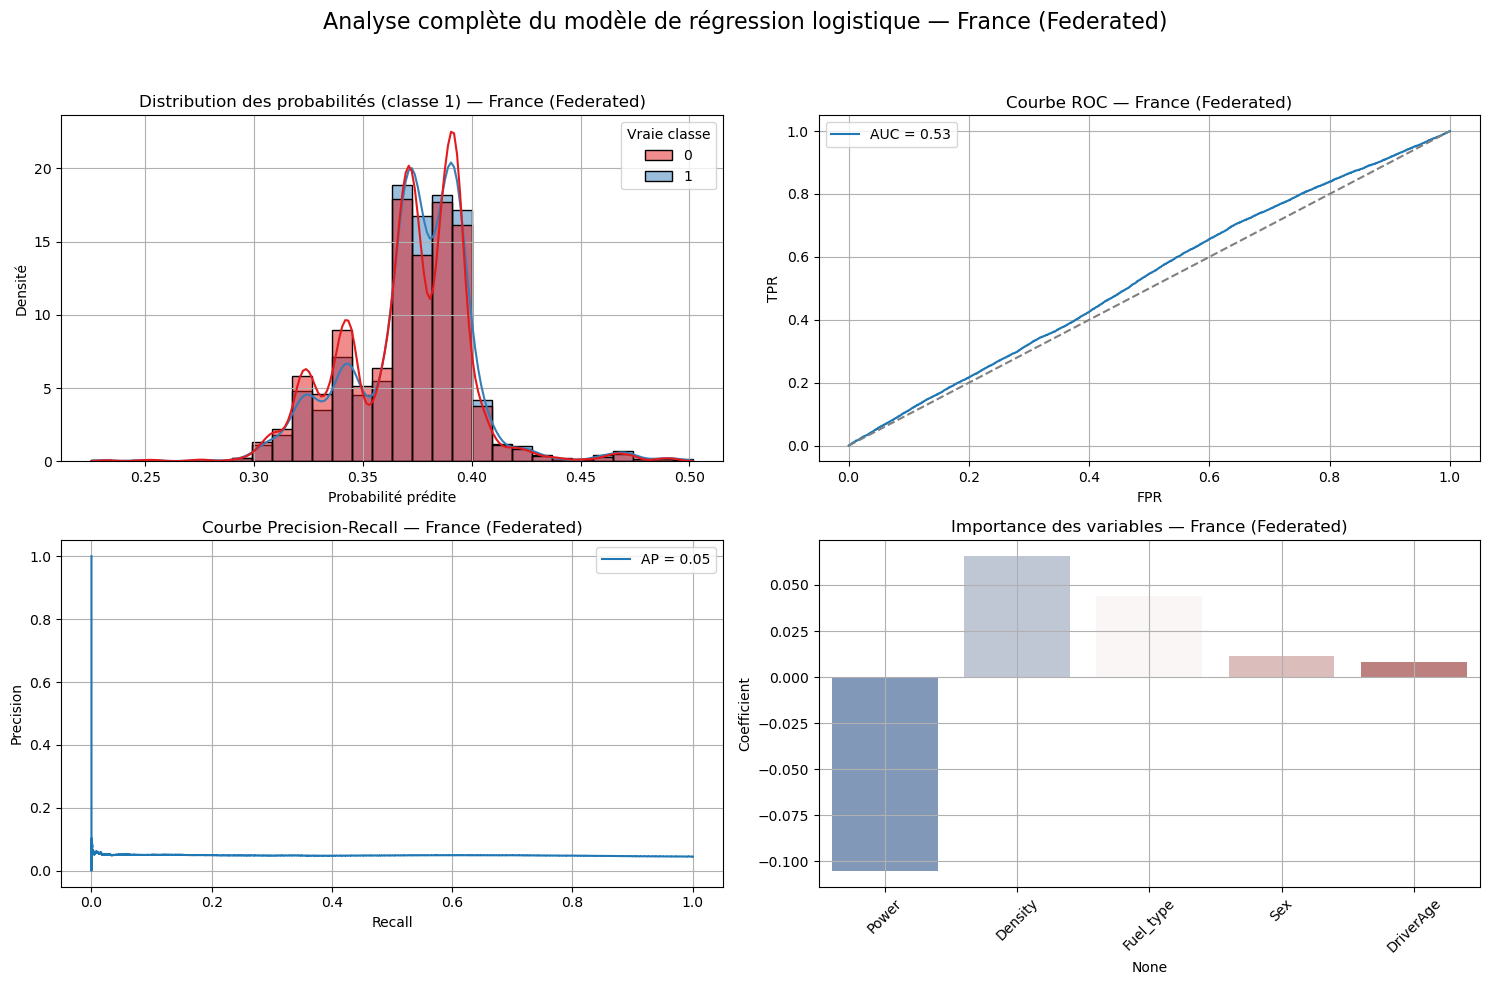


📋 Classification Report — France (Federated)
              precision    recall  f1-score   support

           0       0.96      0.36      0.52    260435
           1       0.05      0.70      0.09     12361

    accuracy                           0.37    272796
   macro avg       0.51      0.53      0.31    272796
weighted avg       0.92      0.37      0.50    272796

📌 AUC ROC : 0.5292
📌 Average Precision (PR AUC) : 0.0489
🧮 Confusion Matrix :
 [[ 92997 167438]
 [  3664   8697]]


In [5]:
analyze_logistic_model(y_test, y_pred, y_proba, coefs,name='France (Federated)')

In [3]:
dict_fr= {'dataframe':df_fr,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dict_be= {'dataframe':df_be,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dict_eu= {'dataframe':df_eu,
            'X_test':None,
            'y_test':None,
            'y_proba_local':None,
            'y_pred_local':None,
            'y_pred_global':None,
            'y_proba_global':None,
            'best_threshold':None,
            'coefs':None}

dataframes= [dict_fr, dict_be, dict_eu]

In [4]:
def setup_local_models(dataframes):
    for df in dataframes:
        lr=FederatedLogisticRegression(df['dataframe'])
        X_test= lr.X_test
        y_test= lr.y_test
        y_proba, y_pred, coefs = lr.logistic_regression()
        df['X_test']=X_test
        df['y_test']=y_test
        df['y_proba_local']=y_proba
        df['y_pred_local']=y_pred
        df['coefs']=coefs
    return dataframes

In [5]:
#dataframes= setup_local_models(dataframes)
#dataframes
dict_be["dataframe"]

,Exposure,Power,DriverAge,Fuel_type,Density,Sex,Sinistre
0,1.000000,77,50,0,13928,1,1
1,1.000000,66,64,0,13928,0,0
2,1.000000,70,60,1,13928,1,0
3,1.000000,57,77,0,13928,1,0
4,0.046575,70,28,0,13928,0,1
...,...,...,...,...,...,...,...
163207,1.000000,40,37,1,259,1,0
163208,1.000000,55,44,1,259,1,0
163209,1.000000,40,50,1,259,1,0
163210,1.000000,66,43,0,259,1,0


In [6]:
def federated_averaging(dataframes):
    avg_coefs = {}
    
    for df in dataframes:
        for key, value in df['coefs'].items():
            if key not in avg_coefs:
                avg_coefs[key] = []
            avg_coefs[key].append(value)
    
    # Calculer la moyenne
    for key in avg_coefs.keys():
        avg_coefs[key] = sum(avg_coefs[key]) / len(avg_coefs[key])
    
    return avg_coefs

In [7]:
def setup_local_models(dataframes):
    for df in dataframes:
        lr=FederatedLogisticRegression(df["dataframe"])
        X_test= lr.X_test
        y_test= lr.y_test
        y_proba, y_pred, coefs = lr.logistic_regression()
        df['X_test']=X_test
        df['y_test']=y_test
        df['y_proba_local']=y_proba
        df['y_pred_local']=y_pred
        df['coefs']=coefs
        df['best_threshold']=lr.best_threshold
        df['lr'] = lr
    return dataframes

def setup_model(dataframes):
    dataframes = setup_local_models(dataframes)
    coeffs = federated_averaging(dataframes)
    
    for df in dataframes:
        lr = df["lr"]  
        threshold = df["best_threshold"]
        df["y_proba_global"], df["y_pred_global"] = lr.predict_with_coefficients(df["X_test"], coeffs, best_threshold=threshold)
    return dataframes

In [8]:
dataframes= setup_model(dataframes)
dataframes

[1 1 1 ... 1 0 0]
[1 0 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


[{'dataframe':          Exposure  Power  DriverAge  Fuel_type  Density  Sex  Sinistre
  0         0.09000     43         46          1       76    0         0
  1         0.84000     43         46          1       76    1         0
  2         0.52000     40         38          0     3003    1         0
  3         0.45000     40         38          0     3003    1         0
  4         0.15000     43         41          1       60    0         0
  ...           ...    ...        ...        ...      ...  ...       ...
  1091177   0.00274      4         54          0     3317    0         0
  1091178   0.00274      4         41          0     9850    1         0
  1091179   0.00274      6         45          1     1323    1         0
  1091180   0.00274      4         60          0       95    1         0
  1091181   0.00274      7         29          1       65    1         0
  
  [1091182 rows x 7 columns],
  'X_test':          Power  DriverAge  Fuel_type  Density  Sex
  346702      5

In [21]:
pd.Series(dataframes[2]["y_pred_global"]).value_counts()


1    581335
0     11760
Name: count, dtype: int64